<a href="https://colab.research.google.com/github/till-tietz/voting_data_ocr/blob/master/DDR_gemeinden_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install imageio
!pip install re
!pip install opencv2
!pip install cluster
!pip install path
!pip install cv
!pip install Pillow
!pip install layoutparser 
!pip install layoutparser[layoutmodels] 
!pip install layoutparser[ocr]
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [32]:
import matplotlib.pyplot as plt
import statistics as stat
import math
import pytesseract 
import imageio
import re
import cv
import cv2
import PIL
import numpy as np
import pandas as pd
import layoutparser as lp
import torchvision
import detectron2
import cluster
from pathlib import Path
from pytesseract import Output
from tensorflow.keras.preprocessing import image
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from PIL import Image

In [3]:
!which tesseract

/usr/bin/tesseract


In [4]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [16]:
#adding drive as root directory
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
#getting paths to image files
path = "/content/gdrive/My Drive/DDR_gemeinde_data"
img_files = [f for f in listdir(path) if isfile(join(path, f))]
img_files = ["/content/gdrive/My Drive/DDR_gemeinde_data/" + s for s in img_files]

In [18]:
#define function to load images and turn them into arrays 
def img_load(files):
  img_array = []
  for i in range(len(files)):
    img_i = image.img_to_array(image.load_img(files[i]), dtype = 'uint8')
    img_array.append(img_i)
  return img_array

In [19]:
img_files[18]

'/content/gdrive/My Drive/DDR_gemeinde_data/page_31.png'

In [ ]:
img = img_load(files = img_files[18:19])[0]
cv2_imshow(img)

In [24]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.bilateralFilter(image,9,75,75)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
      angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [ ]:
img = get_grayscale(image = img)
img = remove_noise(image = img)
img = opening(image = img)
cv2_imshow(img)

In [26]:
ocr = pytesseract.image_to_data(img, output_type = Output.DICT)

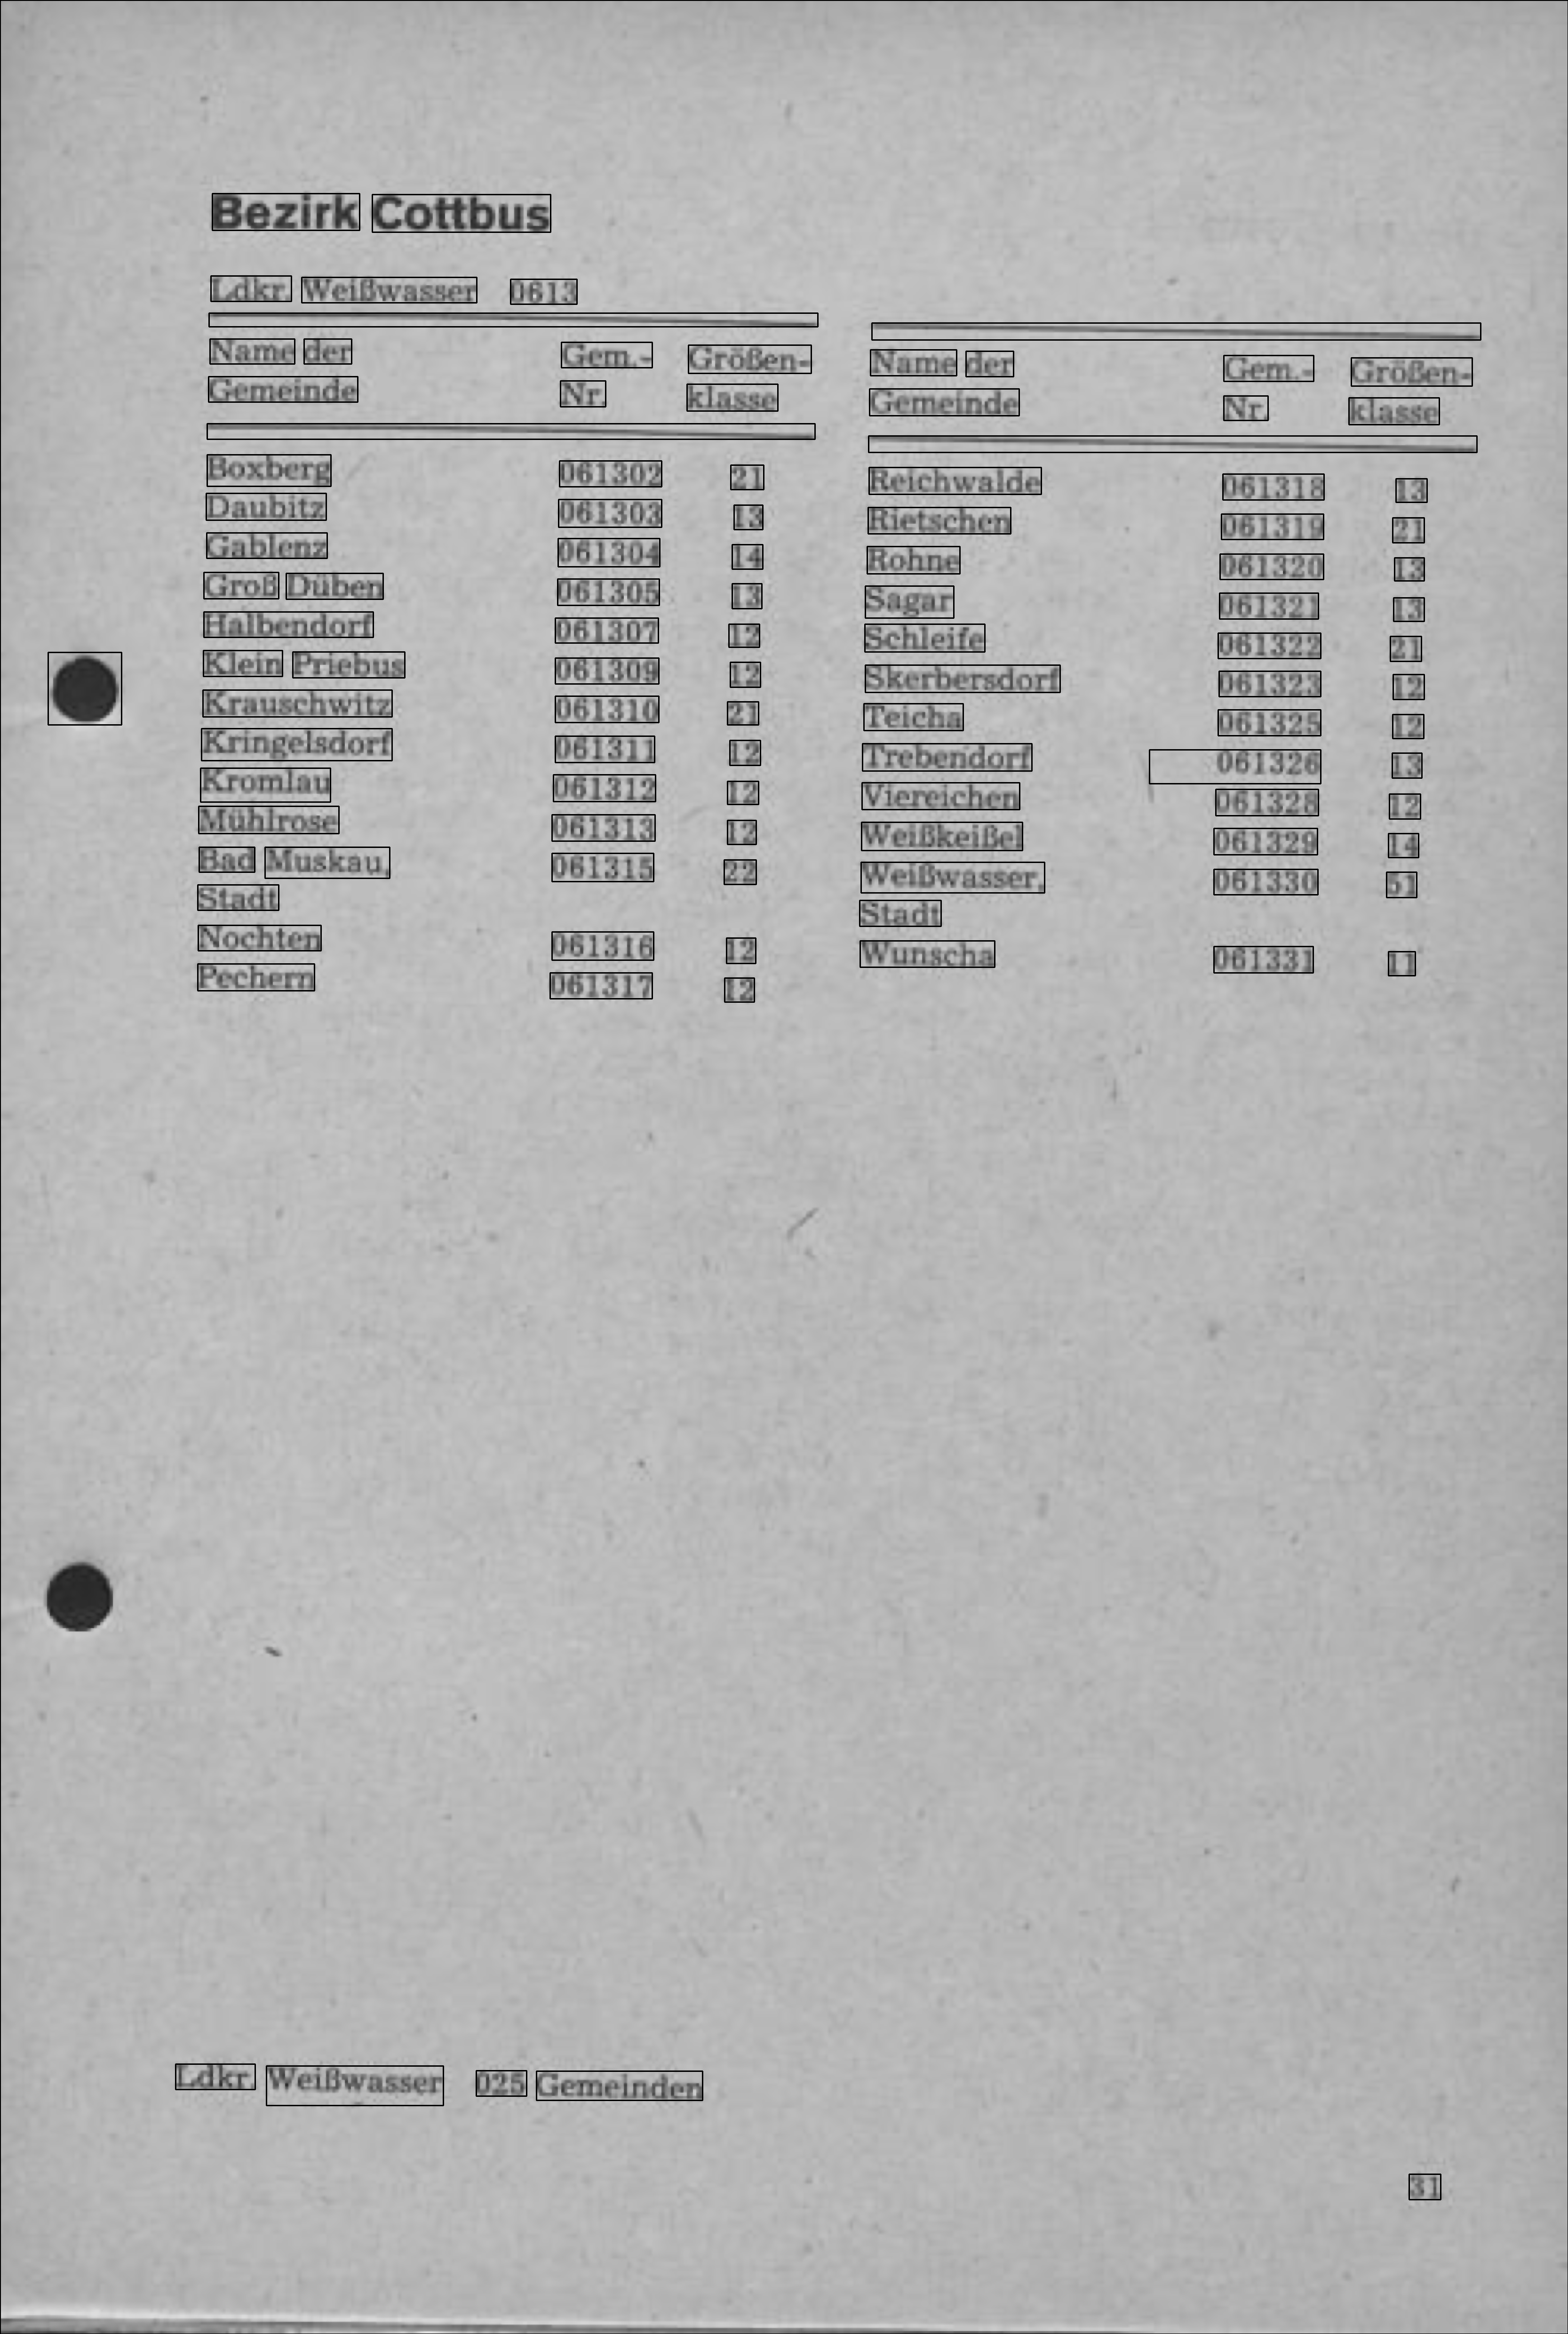

In [29]:
n_boxes = len(ocr['text'])
for i in range(n_boxes):
    if int(ocr['conf'][i]) > 0:
        (x, y, w, h) = (ocr['left'][i], ocr['top'][i], ocr['width'][i], ocr['height'][i])
        img_2 = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img_2)


In [42]:
#detect rows by y axis position cluster
cl = cluster.HierarchicalClustering(ocr['top'], lambda x,y: abs(x-y))
cl = cl.getlevel(20)

In [48]:
#get data ids of elements in each row to acces text with 
row_data_ids = []
for i in range(len(cl)):
  def condition(x, vals): return x in vals
  row_data_ids.append([idx for idx, element in enumerate(ocr['top']) if condition(element, cl[i])])

In [57]:
#sort rows
row_data_ids = sorted(row_data_ids, key=lambda x: x[0])

In [68]:
#get text for each row 
[ocr['text'][i] for i in row_data_ids[10]]

['', 'Boxberg', '061302', '21', 'Reichwalde', '061318', '13']